In [1]:
%matplotlib inline

from __future__ import print_function, division

# Author: Xiang Wang
# E-mail: wx15857152367@163.com

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader


import torchvision
from torchvision import datasets, models, transforms, models

from tensorboardX import SummaryWriter

import numpy as np
import time
import os
import copy
import pickle

import matplotlib.pyplot as plt

plt.ion()   # interactive mode

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 一、数据加载与处理

In [3]:
# Data ToTensor and normalization for training

data_transforms = transforms.Compose([transforms.ToTensor(), 
                                      transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                     ])


In [4]:
# load dataset

# 加载图片
image_datasets = datasets.ImageFolder('C:/1.PlayGround/GirlPicture32PIL2/', transform=data_transforms)

# 得到可batch的数据格式
data_loaders = DataLoader(image_datasets, batch_size=64, shuffle=True, num_workers=0)



In [5]:
train_data = data_loaders

In [84]:
next(iter(train_data))[0].shape

torch.Size([64, 3, 32, 32])

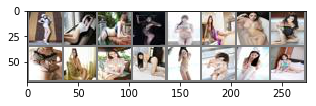

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.detach().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_data))
inputs = inputs[0:16]
# Make a grid from batc
out = torchvision.utils.make_grid(inputs)
plt.figure(figsize=(5,5))

imshow(out)

## 二、创建模型

In [7]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [8]:
class DCGAN_D(nn.Module):
    def __init__(self):
        super(DCGAN_D, self).__init__()
        
        self.conv = nn.Sequential(

            nn.Conv2d(3, 64,  kernel_size=4,  stride=2, padding=1),
            nn.InstanceNorm2d(64, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128,  kernel_size=4,  stride=2, padding=1),
            nn.InstanceNorm2d(128, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256,  kernel_size=4,  stride=2, padding=1),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(0.2,inplace=True),

        )
        
        self.fc = nn.Sequential(
            nn.Conv2d(256, 1,  kernel_size=4,  stride=1, padding=0),
        )
        initialize_weights(self)

        
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)

        x = x.view(x.shape[0], -1)
        return x

In [9]:
class DCGAN_G(nn.Module):
    def __init__(self, noise_dim=100):
        super(DCGAN_G, self).__init__()
        
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=100, out_channels=256, kernel_size=4, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        initialize_weights(self)
        
    def forward(self, x):
        x = x.view(x.shape[0], 100, 1, 1) 
        x = self.conv(x)

        return x

In [10]:
G_net = DCGAN_G()
D_net = DCGAN_D()

### 三、设置必要的参数

In [22]:
G_net = G_net.to(device)
D_net = D_net.to(device)

In [23]:
# 使用 adam 来进行训练
def get_optimizer(net, lr=1e-4):
    optimizer = torch.optim.Adam(net.parameters(), lr, betas=(0.5, 0.9))
    return optimizer

optimizer_D = get_optimizer(D_net)
optimizer_G = get_optimizer(G_net)

In [24]:
# 损失函数构建

# gradient_penalty的构建
def gradient_penalty(D_net, real_images, fake_images, device=device):

    # 随机生成batch_size个随机值（0～1），并将其广播成和数据一样的格式
    # 其目前是为了得到介于真实数据和生成数据之间的点
    epsilon = torch.rand(batch_size, 1, device=device, requires_grad=True)
    epsilon_exp = epsilon.expand(batch_size, real_images.nelement()/batch_size).contiguous().view(real_images.size())
    epsilon_exp = epsilon_exp.to(device)
    
    # 生成真实数据和生成数据之间的点
    inter_images = epsilon_exp * real_images.data + (1 - epsilon_exp) * fake_images.data
    inter_images = Variable(inter_images, requires_grad=True)
    
    
    # 用判别模型来判断inter_images的真假
    inter_loss = D_net(inter_images)
    
    # 得到梯度
    gradients = grad(outputs=inter_loss, inputs=inter_images, grad_outputs=torch.ones(inter_loss.size()).to(device), 
                                    create_graph=True, retain_graph=True, only_inputs=True)[0]
    
    gradients = gradients.view(gradients.size(0), -1)
    
    # 得到WGAN-GP中添加的gradient_penalty正则项
    return ((gradients.norm(2, dim=1) - 1) ** 2).mean()


# W损失的定义
# 返回带正则项的损失函数（用于反向传播）；对于真实图片的判别；对于生成图片的判别
def wasserstein_loss(D_net, real_images, fake_images, device=device, gp_lambda=10):
    
    return ((D_net(fake_images) - D_net(real_images)).mean() + gradient_penalty(D_net, real_images, fake_images) * gp_lambda),\
            (D_net(real_images)).mean(), (D_net(fake_images)).mean()


In [25]:
batch_size = 64
NOISE_DIM =100

### 四、训练模型

In [26]:
def train_model(D_net, G_net, D_optimizer, G_optimizer, show_every=250, noise_size=100, 
                num_epochs=100,  n_critic = 5, lambda_=10):
    since = time.time()
   
    writer = SummaryWriter('log')
    
    iter_count = 0
    
    # z_sample = (torch.rand(64, noise_size) - 0.5) / 0.5  # 生成（-1 ~ 1）的噪声
    z_sample = Variable(torch.randn(batch_size, noise_size))
    z_sample = z_sample.to(device)

    for epoch in range(num_epochs):
        print('epoch: ', epoch)
        # 因为每次epoch结束就让其生成图片，所以在开始时先.train（）一下
        G_net.train()

        for i,(real_images, label) in  enumerate(train_data):
            # 因为最后一个batch可能数量不符，所以舍弃掉
            if i == train_data.dataset.__len__() // batch_size:
                break


   #******** 1. 训练判别网络 *****************************#
            
            D_optimizer.zero_grad()
        
            # 首先得到真实数据
            real_images = real_images.cuda()# 真实数据  

            D_real_loss = -torch.mean(D_net(real_images))
            
            # 用生成器生成数据
            sample_noise = torch.rand((batch_size, noise_size))
            sample_noise = sample_noise.cuda()
            fake_images = G_net(sample_noise) # 生成的假的数据

            # 计算损失，进行反向更新，更新判别器
            D_loss, D_real_loss, D_fake_loss = wasserstein_loss(D_net, real_images, fake_images)
            W_loss = D_real_loss - D_fake_loss

            
            D_loss.backward(retain_graph=True)
            D_optimizer.step()
    #******** 2. 训练生成网络 ***************************#
            if ((i+1) % n_critic) == 0:
                G_optimizer.zero_grad()

                fake_images = G_net(sample_noise) # 生成的假的数据
                
                # 用生成的数据得到判别网络的得分
                G_loss = -torch.mean(D_net(fake_images))
            
                G_loss.backward()
                G_optimizer.step()

                iter_count += 1
                if (iter_count < 10 or iter_count % show_every == 0):
            
                    time_elapsed = time.time() - since
                    print('Iter: {}, real: {:.4}, fake:{:.4}'.format(iter_count, (D_real_loss).item(), D_fake_loss.item()))
                    print('Iter: {}, D: {:.4}, G:{:.4}, W:{:.4}'.format(iter_count, D_loss.item(), G_loss.item(), W_loss.item()))
                    
                    print('Time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

                    
                    
        with torch.no_grad():
            out = torchvision.utils.make_grid(G_net(z_sample).cpu()[0:16])
            plt.figure(figsize=(5,5))
            imshow(out)

            plt.show()
        
        # 使用 tensorboard 
        writer.add_scalar('W_Loss', W_loss.item(), epoch)
        writer.add_scalar('G_loss', G_loss.item(), epoch) 
        
    return D_net, G_net

epoch:  0
Iter: 1, real: 24.01, fake:20.44
Iter: 1, D: -3.103, G:-20.14, W:3.571
Time: 0m 7s
Iter: 2, real: 23.18, fake:20.57
Iter: 2, D: -2.527, G:-20.53, W:2.614
Time: 0m 8s
Iter: 3, real: 24.47, fake:22.13
Iter: 3, D: -2.037, G:-21.95, W:2.347
Time: 0m 8s
Iter: 4, real: 25.08, fake:21.89
Iter: 4, D: -2.856, G:-21.48, W:3.197
Time: 0m 9s
Iter: 5, real: 26.24, fake:23.23
Iter: 5, D: -2.596, G:-22.24, W:3.011
Time: 0m 9s
Iter: 6, real: 24.9, fake:21.27
Iter: 6, D: -2.669, G:-21.02, W:3.625
Time: 0m 10s
Iter: 7, real: 23.05, fake:19.48
Iter: 7, D: -3.041, G:-18.66, W:3.563
Time: 0m 10s
Iter: 8, real: 24.22, fake:20.29
Iter: 8, D: -3.117, G:-20.22, W:3.929
Time: 0m 11s
Iter: 9, real: 23.46, fake:21.06
Iter: 9, D: -2.308, G:-21.06, W:2.407
Time: 0m 11s
Iter: 100, real: 25.6, fake:21.47
Iter: 100, D: -3.34, G:-21.31, W:4.131
Time: 0m 56s


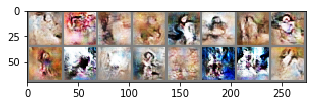

epoch:  1
Iter: 200, real: 22.23, fake:19.2
Iter: 200, D: -2.852, G:-18.88, W:3.035
Time: 1m 42s


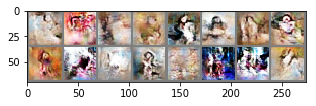

epoch:  2
Iter: 300, real: 23.99, fake:20.37
Iter: 300, D: -3.242, G:-19.91, W:3.62
Time: 2m 26s
Iter: 400, real: 24.19, fake:21.11
Iter: 400, D: -2.693, G:-20.18, W:3.079
Time: 3m 11s


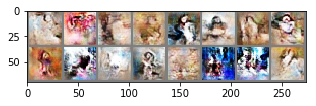

epoch:  3
Iter: 500, real: 23.45, fake:21.08
Iter: 500, D: -2.165, G:-20.97, W:2.372
Time: 3m 57s


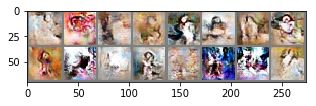

epoch:  4
Iter: 600, real: 23.28, fake:20.76
Iter: 600, D: -2.459, G:-20.25, W:2.517
Time: 4m 42s


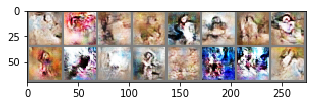

epoch:  5
Iter: 700, real: 22.18, fake:19.22
Iter: 700, D: -2.865, G:-17.71, W:2.964
Time: 5m 27s
Iter: 800, real: 23.4, fake:20.27
Iter: 800, D: -2.543, G:-19.73, W:3.127
Time: 6m 12s


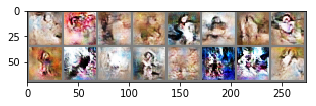

epoch:  6
Iter: 900, real: 22.05, fake:18.89
Iter: 900, D: -2.489, G:-19.58, W:3.16
Time: 6m 57s


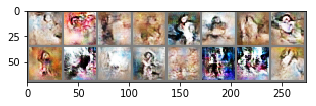

epoch:  7
Iter: 1000, real: 22.35, fake:19.34
Iter: 1000, D: -2.81, G:-18.85, W:3.012
Time: 7m 41s


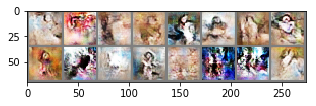

epoch:  8
Iter: 1100, real: 25.58, fake:23.0
Iter: 1100, D: -2.259, G:-22.66, W:2.584
Time: 8m 26s
Iter: 1200, real: 22.64, fake:19.68
Iter: 1200, D: -2.872, G:-19.14, W:2.958
Time: 9m 10s


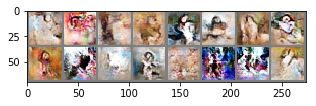

epoch:  9
Iter: 1300, real: 24.39, fake:21.56
Iter: 1300, D: -2.548, G:-21.12, W:2.828
Time: 9m 54s


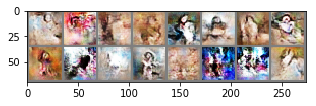

epoch:  10
Iter: 1400, real: 23.31, fake:19.89
Iter: 1400, D: -3.246, G:-19.7, W:3.423
Time: 10m 38s
Iter: 1500, real: 26.82, fake:23.23
Iter: 1500, D: -1.647, G:-22.06, W:3.588
Time: 11m 22s


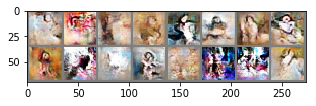

epoch:  11
Iter: 1600, real: 24.97, fake:21.69
Iter: 1600, D: -3.184, G:-21.45, W:3.275
Time: 12m 7s


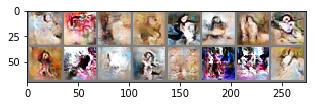

epoch:  12
Iter: 1700, real: 25.9, fake:22.49
Iter: 1700, D: -3.128, G:-22.54, W:3.418
Time: 12m 51s


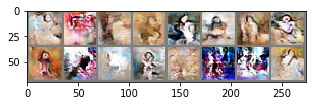

epoch:  13
Iter: 1800, real: 24.92, fake:21.28
Iter: 1800, D: -3.517, G:-21.54, W:3.64
Time: 13m 36s
Iter: 1900, real: 24.4, fake:21.89
Iter: 1900, D: -2.16, G:-20.77, W:2.504
Time: 14m 19s


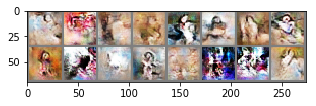

epoch:  14
Iter: 2000, real: 24.89, fake:22.15
Iter: 2000, D: -2.662, G:-21.93, W:2.737
Time: 15m 4s


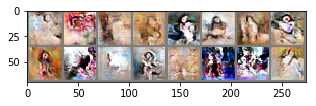

epoch:  15
Iter: 2100, real: 24.83, fake:21.01
Iter: 2100, D: -3.595, G:-20.45, W:3.816
Time: 15m 48s


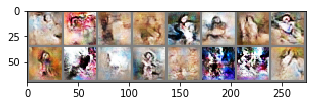

epoch:  16
Iter: 2200, real: 26.89, fake:23.66
Iter: 2200, D: -2.52, G:-22.55, W:3.23
Time: 16m 33s
Iter: 2300, real: 24.28, fake:20.91
Iter: 2300, D: -3.016, G:-20.68, W:3.373
Time: 17m 17s


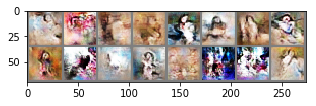

epoch:  17
Iter: 2400, real: 24.44, fake:21.58
Iter: 2400, D: -2.722, G:-21.52, W:2.858
Time: 18m 1s


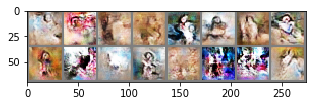

epoch:  18
Iter: 2500, real: 24.8, fake:20.48
Iter: 2500, D: -3.938, G:-20.37, W:4.322
Time: 18m 45s
Iter: 2600, real: 23.26, fake:20.72
Iter: 2600, D: -2.437, G:-20.34, W:2.541
Time: 19m 29s


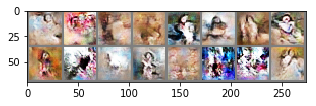

epoch:  19
Iter: 2700, real: 24.86, fake:21.09
Iter: 2700, D: -3.5, G:-20.6, W:3.771
Time: 20m 14s


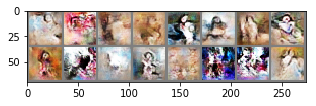

epoch:  20
Iter: 2800, real: 25.04, fake:22.18
Iter: 2800, D: -2.725, G:-22.19, W:2.858
Time: 20m 58s


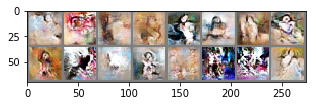

epoch:  21
Iter: 2900, real: 24.86, fake:21.79
Iter: 2900, D: -2.954, G:-21.23, W:3.064
Time: 21m 43s
Iter: 3000, real: 24.99, fake:21.29
Iter: 3000, D: -3.179, G:-20.38, W:3.697
Time: 22m 27s


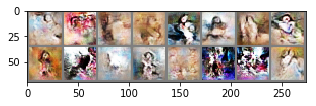

epoch:  22
Iter: 3100, real: 25.21, fake:21.68
Iter: 3100, D: -2.89, G:-21.33, W:3.533
Time: 23m 11s


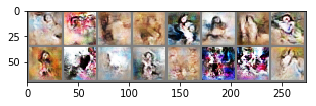

epoch:  23
Iter: 3200, real: 25.29, fake:21.47
Iter: 3200, D: -3.525, G:-21.0, W:3.822
Time: 23m 56s


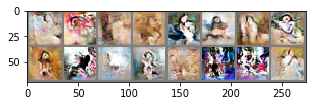

epoch:  24
Iter: 3300, real: 22.83, fake:19.0
Iter: 3300, D: -3.422, G:-19.09, W:3.838
Time: 24m 40s
Iter: 3400, real: 22.27, fake:19.71
Iter: 3400, D: -2.469, G:-19.01, W:2.556
Time: 25m 24s


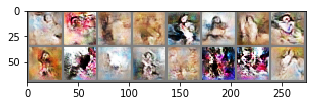

epoch:  25
Iter: 3500, real: 23.0, fake:20.14
Iter: 3500, D: -2.734, G:-20.22, W:2.861
Time: 26m 8s


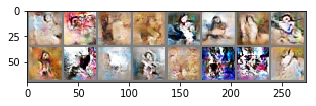

epoch:  26
Iter: 3600, real: 22.09, fake:19.43
Iter: 3600, D: -2.157, G:-19.28, W:2.664
Time: 26m 53s


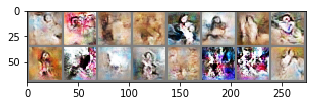

epoch:  27
Iter: 3700, real: 24.29, fake:20.39
Iter: 3700, D: -3.078, G:-20.52, W:3.905
Time: 27m 37s
Iter: 3800, real: 25.1, fake:20.33
Iter: 3800, D: -4.458, G:-19.57, W:4.77
Time: 28m 21s


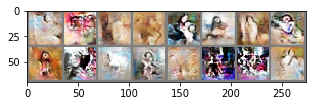

epoch:  28
Iter: 3900, real: 25.13, fake:22.89
Iter: 3900, D: -1.895, G:-22.43, W:2.242
Time: 29m 5s


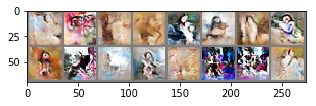

epoch:  29
Iter: 4000, real: 23.48, fake:20.43
Iter: 4000, D: -2.013, G:-20.71, W:3.046
Time: 29m 50s
Iter: 4100, real: 24.73, fake:21.55
Iter: 4100, D: -2.763, G:-21.22, W:3.18
Time: 30m 34s


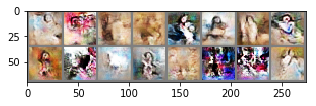

epoch:  30
Iter: 4200, real: 25.97, fake:23.03
Iter: 4200, D: -1.763, G:-22.27, W:2.93
Time: 31m 18s


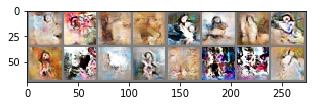

epoch:  31
Iter: 4300, real: 24.22, fake:21.64
Iter: 4300, D: -1.799, G:-21.65, W:2.579
Time: 32m 2s


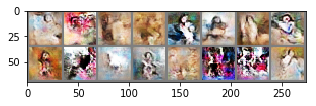

epoch:  32
Iter: 4400, real: 23.47, fake:20.56
Iter: 4400, D: -2.584, G:-20.2, W:2.907
Time: 32m 47s
Iter: 4500, real: 25.78, fake:22.78
Iter: 4500, D: -2.593, G:-22.0, W:3.008
Time: 33m 31s


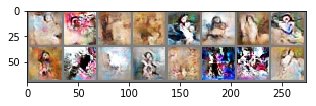

epoch:  33
Iter: 4600, real: 23.32, fake:21.05
Iter: 4600, D: -2.144, G:-20.55, W:2.274
Time: 34m 15s


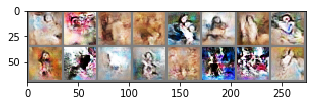

epoch:  34
Iter: 4700, real: 23.67, fake:21.46
Iter: 4700, D: -2.147, G:-20.8, W:2.203
Time: 34m 59s


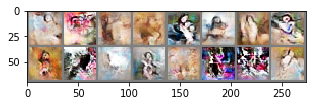

epoch:  35
Iter: 4800, real: 25.16, fake:22.71
Iter: 4800, D: -1.721, G:-22.12, W:2.454
Time: 35m 44s
Iter: 4900, real: 24.53, fake:22.06
Iter: 4900, D: -2.371, G:-21.98, W:2.468
Time: 36m 28s


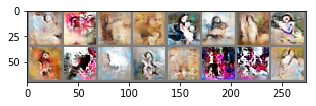

epoch:  36
Iter: 5000, real: 23.54, fake:20.9
Iter: 5000, D: -2.549, G:-20.68, W:2.634
Time: 37m 12s


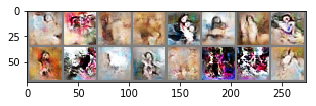

epoch:  37
Iter: 5100, real: 23.33, fake:19.88
Iter: 5100, D: -3.039, G:-19.89, W:3.454
Time: 37m 57s
Iter: 5200, real: 24.29, fake:20.99
Iter: 5200, D: -3.159, G:-20.4, W:3.3
Time: 38m 41s


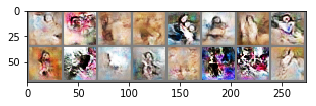

epoch:  38
Iter: 5300, real: 24.11, fake:21.33
Iter: 5300, D: -2.715, G:-20.92, W:2.785
Time: 39m 25s


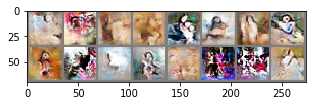

epoch:  39
Iter: 5400, real: 23.65, fake:20.77
Iter: 5400, D: -2.388, G:-20.79, W:2.879
Time: 40m 9s


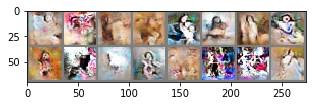

epoch:  40
Iter: 5500, real: 23.13, fake:20.48
Iter: 5500, D: -2.526, G:-20.46, W:2.651
Time: 40m 54s
Iter: 5600, real: 25.19, fake:22.7
Iter: 5600, D: -2.437, G:-22.27, W:2.494
Time: 41m 38s


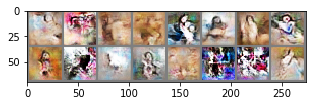

epoch:  41
Iter: 5700, real: 22.71, fake:21.04
Iter: 5700, D: -1.236, G:-21.15, W:1.668
Time: 42m 22s


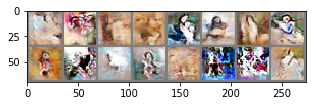

epoch:  42
Iter: 5800, real: 25.19, fake:21.97
Iter: 5800, D: -3.053, G:-21.68, W:3.226
Time: 43m 6s


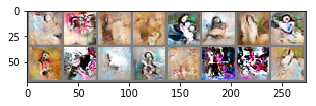

epoch:  43
Iter: 5900, real: 24.94, fake:21.66
Iter: 5900, D: -2.544, G:-21.02, W:3.283
Time: 43m 51s
Iter: 6000, real: 25.62, fake:22.44
Iter: 6000, D: -2.904, G:-22.38, W:3.178
Time: 44m 35s


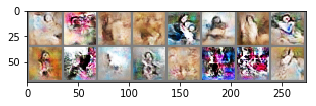

epoch:  44
Iter: 6100, real: 22.5, fake:19.96
Iter: 6100, D: -2.233, G:-19.71, W:2.537
Time: 45m 19s


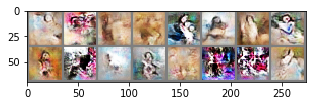

epoch:  45
Iter: 6200, real: 25.34, fake:22.62
Iter: 6200, D: -2.401, G:-22.02, W:2.722
Time: 46m 3s
Iter: 6300, real: 21.44, fake:19.38
Iter: 6300, D: -1.986, G:-18.26, W:2.064
Time: 46m 47s


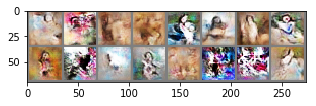

epoch:  46
Iter: 6400, real: 24.85, fake:21.68
Iter: 6400, D: -3.06, G:-21.54, W:3.164
Time: 47m 32s


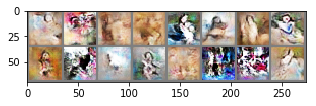

epoch:  47
Iter: 6500, real: 25.43, fake:22.63
Iter: 6500, D: -2.726, G:-22.65, W:2.799
Time: 48m 16s


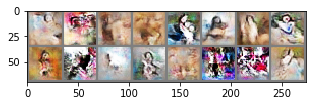

epoch:  48
Iter: 6600, real: 22.78, fake:20.71
Iter: 6600, D: -1.943, G:-20.67, W:2.074
Time: 49m 0s
Iter: 6700, real: 25.94, fake:23.72
Iter: 6700, D: -2.024, G:-23.3, W:2.225
Time: 49m 45s


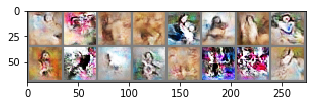

epoch:  49
Iter: 6800, real: 23.06, fake:19.77
Iter: 6800, D: -2.656, G:-20.14, W:3.285
Time: 50m 30s


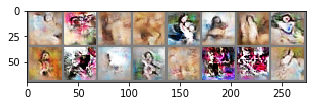

epoch:  50
Iter: 6900, real: 27.7, fake:23.66
Iter: 6900, D: -2.744, G:-22.36, W:4.043
Time: 51m 14s


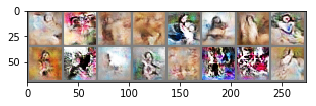

epoch:  51
Iter: 7000, real: 23.12, fake:20.8
Iter: 7000, D: -1.946, G:-20.81, W:2.315
Time: 51m 59s
Iter: 7100, real: 25.34, fake:22.15
Iter: 7100, D: -2.044, G:-21.04, W:3.194
Time: 52m 43s


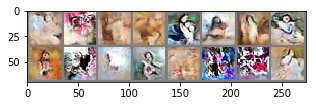

epoch:  52
Iter: 7200, real: 25.03, fake:21.83
Iter: 7200, D: -2.889, G:-21.49, W:3.192
Time: 53m 27s


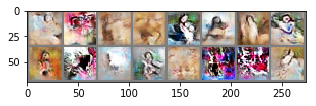

epoch:  53
Iter: 7300, real: 26.25, fake:23.25
Iter: 7300, D: -2.7, G:-23.18, W:2.999
Time: 54m 12s


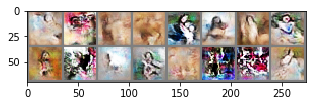

epoch:  54
Iter: 7400, real: 22.35, fake:19.65
Iter: 7400, D: -2.566, G:-18.95, W:2.7
Time: 54m 56s
Iter: 7500, real: 23.69, fake:20.81
Iter: 7500, D: -2.82, G:-20.74, W:2.872
Time: 55m 40s


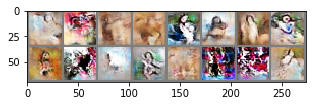

epoch:  55
Iter: 7600, real: 24.88, fake:22.16
Iter: 7600, D: -2.621, G:-22.11, W:2.719
Time: 56m 24s


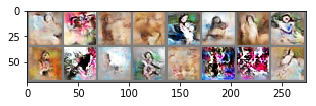

epoch:  56
Iter: 7700, real: 24.01, fake:20.91
Iter: 7700, D: -3.01, G:-20.21, W:3.102
Time: 57m 9s
Iter: 7800, real: 25.66, fake:23.46
Iter: 7800, D: -2.022, G:-22.98, W:2.197
Time: 57m 53s


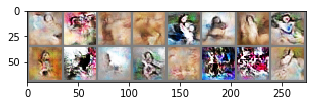

epoch:  57
Iter: 7900, real: 26.77, fake:23.76
Iter: 7900, D: -2.598, G:-23.04, W:3.006
Time: 58m 37s


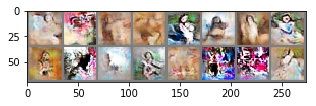

epoch:  58
Iter: 8000, real: 25.53, fake:21.88
Iter: 8000, D: -3.061, G:-20.91, W:3.643
Time: 59m 22s


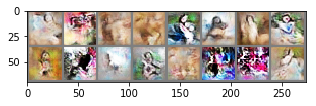

epoch:  59
Iter: 8100, real: 23.88, fake:20.67
Iter: 8100, D: -3.121, G:-20.27, W:3.216
Time: 60m 7s
Iter: 8200, real: 24.05, fake:21.47
Iter: 8200, D: -2.453, G:-21.13, W:2.574
Time: 60m 53s


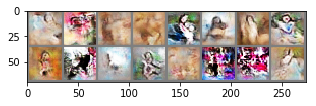

epoch:  60
Iter: 8300, real: 24.32, fake:22.02
Iter: 8300, D: -2.114, G:-21.2, W:2.3
Time: 61m 39s


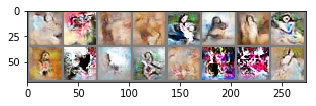

epoch:  61
Iter: 8400, real: 25.64, fake:22.62
Iter: 8400, D: -2.312, G:-22.63, W:3.019
Time: 62m 25s


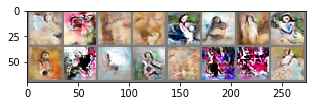

epoch:  62
Iter: 8500, real: 24.99, fake:21.64
Iter: 8500, D: -2.603, G:-21.26, W:3.351
Time: 63m 12s
Iter: 8600, real: 23.73, fake:21.37
Iter: 8600, D: -2.017, G:-20.76, W:2.367
Time: 63m 58s


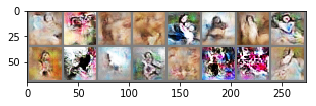

epoch:  63
Iter: 8700, real: 23.78, fake:21.26
Iter: 8700, D: -2.368, G:-21.14, W:2.512
Time: 64m 44s


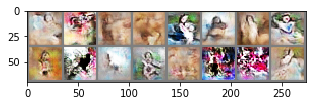

epoch:  64
Iter: 8800, real: 24.61, fake:20.99
Iter: 8800, D: -3.158, G:-20.73, W:3.621
Time: 65m 30s
Iter: 8900, real: 25.69, fake:22.96
Iter: 8900, D: -2.634, G:-22.75, W:2.728
Time: 66m 16s


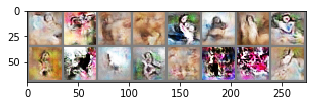

epoch:  65
Iter: 9000, real: 24.51, fake:21.59
Iter: 9000, D: -2.611, G:-20.83, W:2.924
Time: 67m 2s


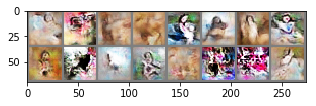

epoch:  66
Iter: 9100, real: 23.78, fake:20.23
Iter: 9100, D: -3.367, G:-19.97, W:3.557
Time: 67m 49s


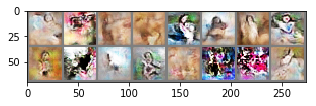

epoch:  67
Iter: 9200, real: 25.56, fake:22.2
Iter: 9200, D: -3.103, G:-22.21, W:3.363
Time: 68m 35s
Iter: 9300, real: 24.53, fake:21.47
Iter: 9300, D: -2.834, G:-20.83, W:3.054
Time: 69m 19s


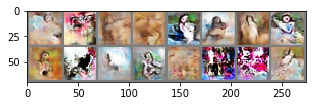

epoch:  68
Iter: 9400, real: 24.45, fake:22.16
Iter: 9400, D: -2.037, G:-21.93, W:2.283
Time: 70m 3s


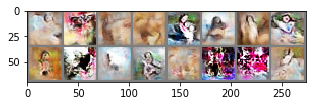

epoch:  69
Iter: 9500, real: 23.13, fake:20.63
Iter: 9500, D: -2.401, G:-20.41, W:2.503
Time: 70m 47s


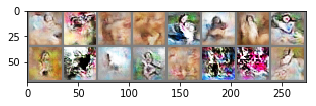

epoch:  70
Iter: 9600, real: 25.63, fake:22.34
Iter: 9600, D: -3.147, G:-22.17, W:3.29
Time: 71m 32s
Iter: 9700, real: 23.81, fake:21.09
Iter: 9700, D: -2.627, G:-20.73, W:2.711
Time: 72m 16s


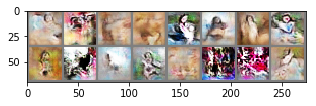

epoch:  71
Iter: 9800, real: 25.76, fake:23.19
Iter: 9800, D: -2.446, G:-23.1, W:2.574
Time: 73m 0s


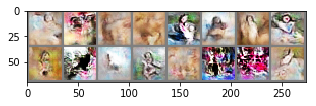

epoch:  72
Iter: 9900, real: 26.79, fake:22.82
Iter: 9900, D: -3.57, G:-22.22, W:3.97
Time: 73m 45s
Iter: 10000, real: 23.22, fake:20.36
Iter: 10000, D: -2.782, G:-20.31, W:2.864
Time: 74m 29s


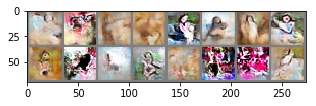

epoch:  73
Iter: 10100, real: 22.78, fake:19.73
Iter: 10100, D: -2.81, G:-19.48, W:3.051
Time: 75m 13s


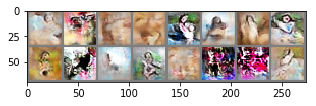

epoch:  74
Iter: 10200, real: 25.77, fake:22.51
Iter: 10200, D: -2.368, G:-21.35, W:3.253
Time: 75m 57s


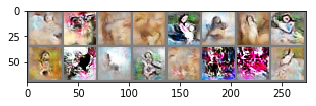

epoch:  75
Iter: 10300, real: 24.01, fake:20.74
Iter: 10300, D: -3.068, G:-20.5, W:3.265
Time: 76m 42s
Iter: 10400, real: 22.82, fake:20.07
Iter: 10400, D: -2.222, G:-19.96, W:2.75
Time: 77m 26s


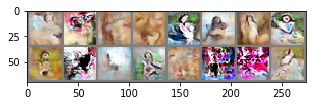

epoch:  76
Iter: 10500, real: 23.47, fake:20.71
Iter: 10500, D: -2.18, G:-20.64, W:2.758
Time: 78m 10s


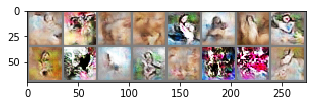

epoch:  77
Iter: 10600, real: 26.23, fake:22.72
Iter: 10600, D: -2.351, G:-22.3, W:3.508
Time: 78m 55s


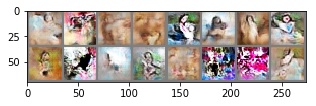

epoch:  78
Iter: 10700, real: 25.95, fake:22.84
Iter: 10700, D: -2.908, G:-22.96, W:3.114
Time: 79m 39s
Iter: 10800, real: 25.22, fake:22.51
Iter: 10800, D: -2.559, G:-22.1, W:2.712
Time: 80m 23s


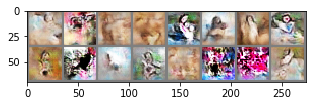

epoch:  79
Iter: 10900, real: 23.48, fake:20.98
Iter: 10900, D: -2.391, G:-20.45, W:2.496
Time: 81m 7s


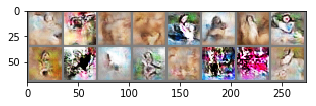

epoch:  80
Iter: 11000, real: 25.25, fake:21.81
Iter: 11000, D: -3.098, G:-21.73, W:3.441
Time: 81m 52s


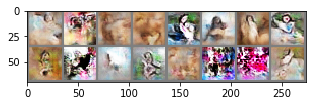

epoch:  81
Iter: 11100, real: 23.3, fake:20.71
Iter: 11100, D: -2.475, G:-20.19, W:2.588
Time: 82m 36s
Iter: 11200, real: 24.91, fake:22.24
Iter: 11200, D: -2.324, G:-21.93, W:2.665
Time: 83m 20s


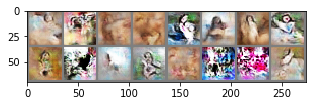

epoch:  82
Iter: 11300, real: 23.59, fake:20.91
Iter: 11300, D: -2.148, G:-20.71, W:2.684
Time: 84m 4s


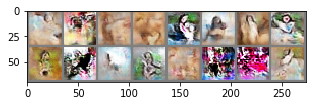

epoch:  83
Iter: 11400, real: 24.01, fake:20.71
Iter: 11400, D: -2.803, G:-21.03, W:3.301
Time: 84m 49s
Iter: 11500, real: 23.64, fake:20.88
Iter: 11500, D: -2.276, G:-20.14, W:2.754
Time: 85m 33s


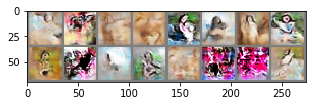

epoch:  84
Iter: 11600, real: 23.24, fake:20.71
Iter: 11600, D: -2.423, G:-20.27, W:2.525
Time: 86m 17s


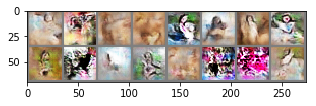

epoch:  85
Iter: 11700, real: 23.32, fake:20.99
Iter: 11700, D: -1.956, G:-20.89, W:2.329
Time: 87m 1s


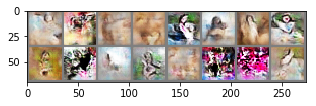

epoch:  86
Iter: 11800, real: 25.11, fake:21.8
Iter: 11800, D: -3.168, G:-21.51, W:3.308
Time: 87m 46s
Iter: 11900, real: 23.56, fake:20.94
Iter: 11900, D: -2.422, G:-21.09, W:2.618
Time: 88m 30s


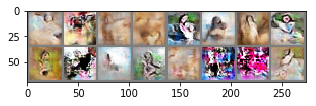

epoch:  87
Iter: 12000, real: 24.72, fake:22.06
Iter: 12000, D: -2.081, G:-22.21, W:2.66
Time: 89m 14s


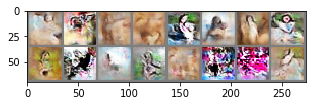

epoch:  88
Iter: 12100, real: 25.81, fake:22.61
Iter: 12100, D: -2.642, G:-22.43, W:3.192
Time: 89m 59s


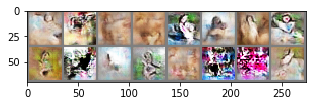

epoch:  89
Iter: 12200, real: 23.25, fake:20.93
Iter: 12200, D: -2.096, G:-20.98, W:2.321
Time: 90m 43s
Iter: 12300, real: 24.94, fake:22.87
Iter: 12300, D: -1.991, G:-23.27, W:2.074
Time: 91m 27s


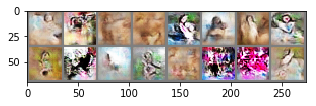

epoch:  90
Iter: 12400, real: 23.66, fake:20.72
Iter: 12400, D: -2.787, G:-20.81, W:2.942
Time: 92m 12s


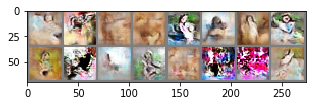

epoch:  91
Iter: 12500, real: 24.72, fake:22.35
Iter: 12500, D: -2.277, G:-22.92, W:2.368
Time: 92m 56s
Iter: 12600, real: 24.71, fake:22.16
Iter: 12600, D: -2.387, G:-21.95, W:2.552
Time: 93m 40s


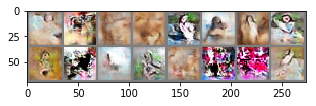

epoch:  92
Iter: 12700, real: 25.44, fake:22.89
Iter: 12700, D: -2.486, G:-22.7, W:2.549
Time: 94m 25s


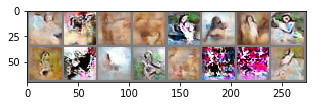

epoch:  93
Iter: 12800, real: 23.92, fake:20.92
Iter: 12800, D: -2.868, G:-20.33, W:3.001
Time: 95m 10s


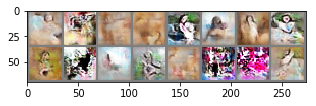

epoch:  94
Iter: 12900, real: 23.05, fake:20.04
Iter: 12900, D: -2.849, G:-19.61, W:3.006
Time: 95m 54s
Iter: 13000, real: 26.02, fake:22.5
Iter: 13000, D: -2.525, G:-21.74, W:3.526
Time: 96m 38s


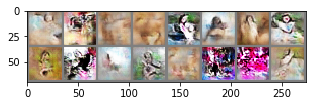

epoch:  95
Iter: 13100, real: 24.32, fake:21.17
Iter: 13100, D: -2.773, G:-20.88, W:3.143
Time: 97m 23s


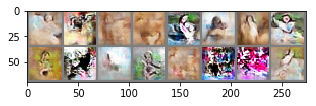

epoch:  96
Iter: 13200, real: 24.62, fake:21.3
Iter: 13200, D: -2.757, G:-20.51, W:3.317
Time: 98m 7s


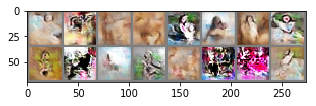

epoch:  97
Iter: 13300, real: 23.64, fake:21.09
Iter: 13300, D: -2.495, G:-21.05, W:2.552
Time: 98m 52s
Iter: 13400, real: 25.03, fake:21.93
Iter: 13400, D: -2.948, G:-22.27, W:3.099
Time: 99m 36s


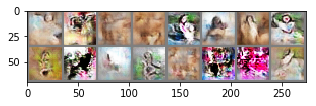

epoch:  98
Iter: 13500, real: 22.96, fake:21.16
Iter: 13500, D: -1.721, G:-21.18, W:1.794
Time: 100m 21s


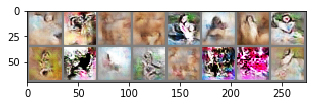

epoch:  99
Iter: 13600, real: 23.93, fake:21.43
Iter: 13600, D: -2.36, G:-21.52, W:2.499
Time: 101m 5s
Iter: 13700, real: 23.89, fake:20.78
Iter: 13700, D: -2.752, G:-19.79, W:3.109
Time: 101m 49s


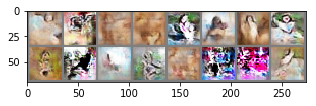

In [27]:
D_net, G_net = train_model(D_net, G_net, optimizer_D, optimizer_G, show_every=100)

用opencv缩放的图训练后的结果：
![WGAN_GP_Picture](https://upload-images.jianshu.io/upload_images/10798244-e621c3f200a35512.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)


用PIL缩放的图训练后的结果：
![WGAN_GP_Picture](https://upload-images.jianshu.io/upload_images/10798244-8bc5471cbb22859e.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)
![WGAN_GP_Picture](https://upload-images.jianshu.io/upload_images/10798244-c48f9b419ddea031.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)
后面有时间再训练

### 五、保存模型

In [28]:
# 模型保存
torch.save(D_net, 'D_net.pkl')
torch.save(G_net, 'G_net.pkl')

In [21]:
# 模型加载
D_net = torch.load('D_net.pkl')    
G_net = torch.load('G_net.pkl')    